# Sheet 6

## 1 Autoencoders: theory and practice

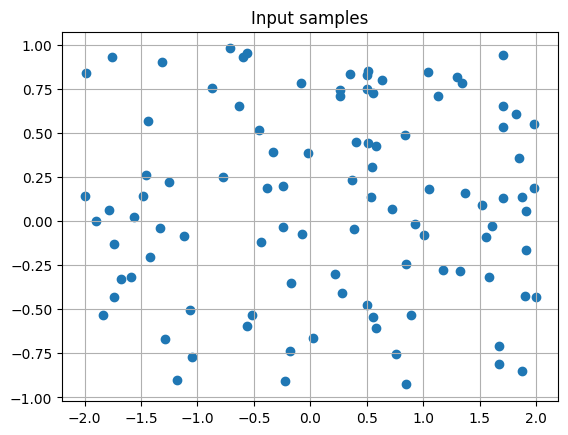

In [1]:
import torch
import matplotlib.pyplot as plt

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


In [3]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

# Define the first autoencoder architecture
class Autoencoder1(nn.Module):
    def __init__(self, input_dim=2, latent_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the second autoencoder architecture
class Autoencoder2(nn.Module):
    def __init__(self, input_dim=2, latent_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the PCA-like architecture
class PCAAutoencoder(nn.Module):
    def __init__(self, input_dim=2, latent_dim=1):
        super().__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



class AutoencoderModule(pl.LightningModule):
    def __init__(self, model_type="Autoencoder1", input_dim=2, latent_dim=1):
        super().__init__()
        if model_type == "Autoencoder1":
            self.autoencoder = Autoencoder1(input_dim, latent_dim)
        elif model_type == "Autoencoder2":
            self.autoencoder = Autoencoder2(input_dim, latent_dim)
        elif model_type == "PCA":
            self.autoencoder = PCAAutoencoder(input_dim, latent_dim)
        else:
            raise ValueError("Invalid model type specified")

        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.forward(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        self.log("train_loss", loss)
        return loss


In [6]:
# start the training using a PyTorch Lightning Trainer
auto_encoder_list = ["Autoencoder1", "Autoencoder2", "PCA"]

for modeltype in auto_encoder_list:
    trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

    autoencoder_module = AutoencoderModule(modeltype)  # TODO: specify the model here
    print("Model overview:", autoencoder_module)

    trainer.fit(autoencoder_module, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name        | Type         | Params | Mode 
-----------------------------------------------------
0 | autoencoder | Autoencoder1 | 563    | train
-----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
/home/jona/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/jona/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder1(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)
Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 134.49it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 132.19it/s, v_num=6]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type         | Params | Mode 
-----------------------------------------------------
0 | autoencoder | Autoencoder2 | 5.5 K  | train
-----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder2(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)
Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 133.62it/s, v_num=7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 130.96it/s, v_num=7]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | autoencoder | PCAAutoencoder | 7      | train
-------------------------------------------------------
7         Trainable params
0         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): PCAAutoencoder(
    (encoder): Linear(in_features=2, out_features=1, bias=True)
    (decoder): Linear(in_features=1, out_features=2, bias=True)
  )
)
Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 172.91it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 165.10it/s, v_num=8]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type         | Params | Mode 
-----------------------------------------------------
0 | autoencoder | Autoencoder1 | 563    | train
-----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder1(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)
Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 137.31it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 134.08it/s, v_num=12]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type         | Params | Mode 
-----------------------------------------------------
0 | autoencoder | Autoencoder2 | 5.5 K  | train
-----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder2(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)
Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 125.41it/s, v_num=13]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 123.42it/s, v_num=13]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model overview: AutoencoderModule(
  (autoencoder): PCAAutoencoder(
    (encoder): Linear(in_features=2, out_features=1, bias=True)
    (decoder): Linear(in_features=1, out_features=2, bias=True)
  )
)



  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | autoencoder | PCAAutoencoder | 7      | train
-------------------------------------------------------
7         Trainable params
0         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 177.58it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 12/12 [00:00<00:00, 172.36it/s, v_num=14]


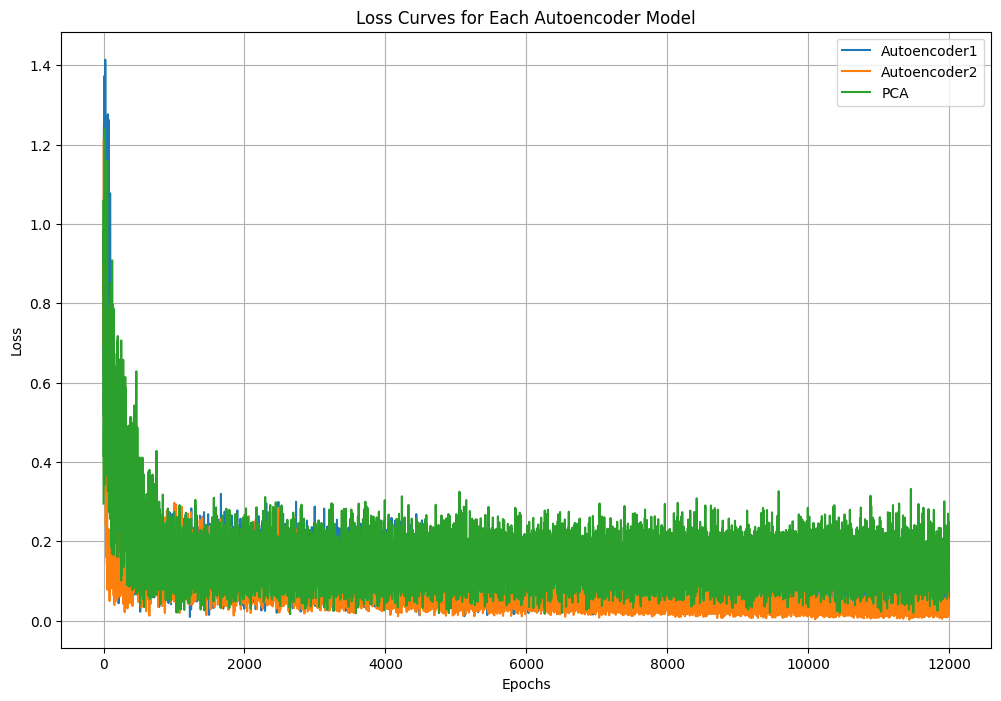

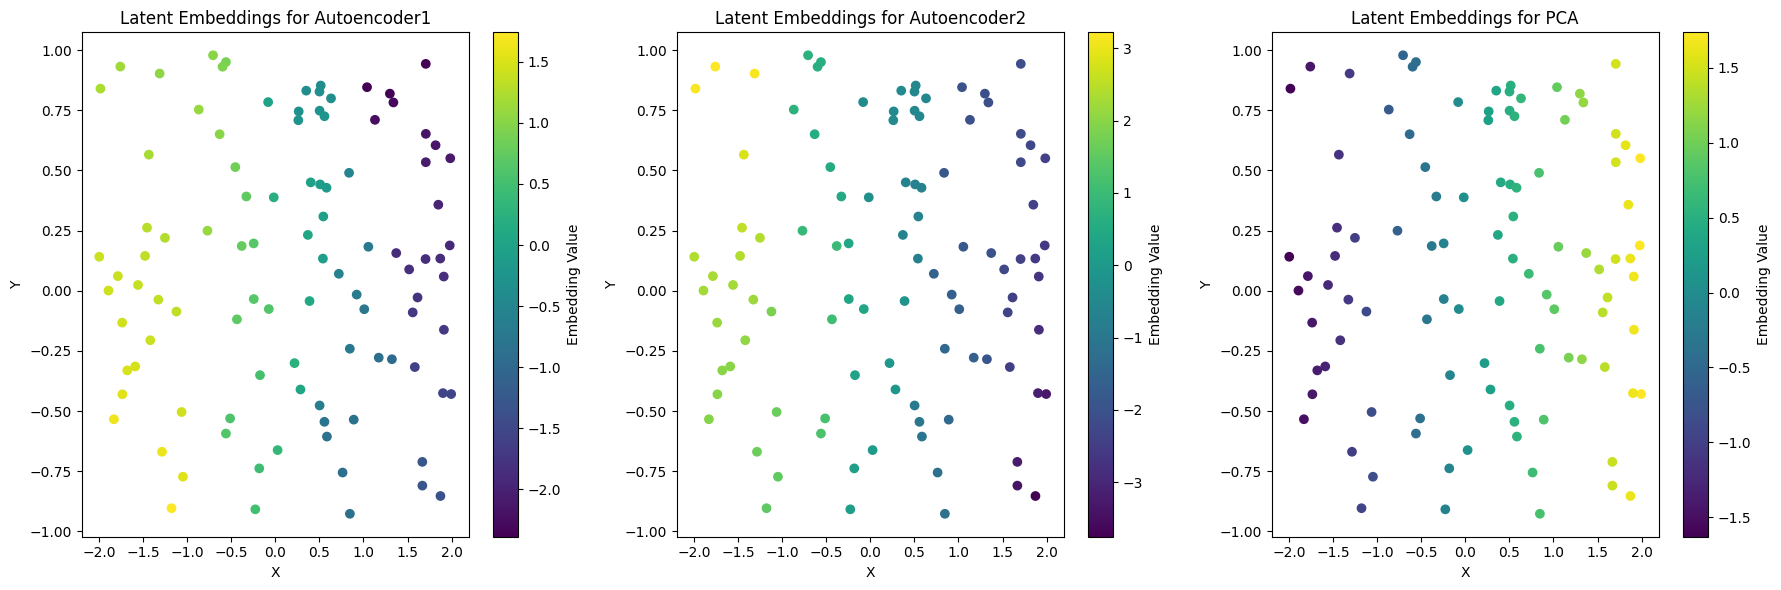

In [8]:
# Initialize a dictionary to store the loss curves for each model
loss_curves = {}

# Initialize a dictionary to store the latent embeddings for each model
latent_embeddings = {}

# Loop over each model type in the list
auto_encoder_list = ["Autoencoder1", "Autoencoder2", "PCA"]

for modeltype in auto_encoder_list:
    trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

    # Initialize the AutoencoderModule with the specified model type
    autoencoder_module = AutoencoderModule(modeltype)
    print("Model overview:", autoencoder_module)

    # Start training using the PyTorch Lightning Trainer
    trainer.fit(autoencoder_module, data_loader)

    # Store the loss curve for the current model
    loss_curves[modeltype] = autoencoder_module.loss_curve

    # After training, get the latent embeddings for the data
    with torch.no_grad():
        # Pass the data through the encoder to get the latent embeddings
        encoder = autoencoder_module.autoencoder.encoder
        latent_embedding = encoder(data).numpy()

    # Store the latent embeddings for the current model
    latent_embeddings[modeltype] = latent_embedding

# 1. Plot the loss curves for each model
plt.figure(figsize=(12, 8))
for modeltype, loss_curve in loss_curves.items():
    plt.plot(loss_curve, label=modeltype)
plt.title("Loss Curves for Each Autoencoder Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the latent embeddings for each model
fig, axes = plt.subplots(1, len(auto_encoder_list), figsize=(18, 6))

for i, modeltype in enumerate(auto_encoder_list):
    # Get the latent embeddings for the current model
    latent_embedding = latent_embeddings[modeltype]
    
    # Plot the embeddings as a scatter plot, with color based on the embedding values
    scatter = axes[i].scatter(data[:, 0], data[:, 1], c=latent_embedding, cmap='viridis')
    axes[i].set_title(f"Latent Embeddings for {modeltype}")
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    fig.colorbar(scatter, ax=axes[i], label="Embedding Value")

plt.tight_layout()
plt.show()


### Discoussion of Results:

- reconstruction error decreases over epochs
- Autoencoder1: embeddings may be more spread out due to a small latent dimension
- Autoencoder2: the latent space might be more compact
- PCA: has the most linear or simple embedding, since it is closer to linear PCA.



### c)

#### Before training (random initialization):
- Autoencoder1: Random, noisy, unstructured curves in the input space
- Autoencoder2: More complex random curves, still unstructured but with more potential for coherence due to the network's complexity
- PCA: Linear curves, potentially resembling a simple line or axis in the input space


#### After training:
- Autoencoder1: Smooth, continuous curves that approximate the data distribution in the input space. Likely reflects a lower-dimensional manifold (e.g., a curve in the 2D space).
- Autoencoder2: More complex, possibly intricate curves that better capture the nonlinear relationships and structure in the input data.
- PCA: Linear paths in the input space, reflecting the primary directions of variance in the data.

In [ ]:
# start the training using a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False)

autoencoder_module = AutoencoderModule()  # TODO: specify the model here
print("Model overview:", autoencoder_module)

trainer.fit(autoencoder_module, data_loader)